In [1]:
!pip install requests

In [3]:
import requests
import zipfile
import io

# URL for the ZIP file
url = "http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip"

# Send a GET request to the URL
response = requests.get(url)

# Ensure the request was successful
if response.status_code == 200:
    # Read the content of the response as a byte stream
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))
    
    # Extract all the contents to a new directory named 'att_faces'
    zip_file.extractall("att_faces")
    
    print("Dataset downloaded and extracted successfully to 'att_faces' folder.")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

Dataset downloaded and extracted successfully to 'att_faces' folder.


In [19]:
import os
import numpy as np
from PIL import Image

def load_images_from_folder(folder):
    images = []
    labels = []
    # Loop through each subject folder (e.g., 's1', 's2', etc.)
    for subject_folder in sorted(os.listdir(folder)):
        # Check if the item is a directory and starts with 's'
        subject_path = os.path.join(folder, subject_folder)
        if os.path.isdir(subject_path) and subject_folder.startswith('s'):
            label = int(subject_folder[1:]) - 1 # Assign a unique integer label
            # Loop through the files inside the subject folder
            for filename in sorted(os.listdir(subject_path)):
                # Check if the file is a PGM image
                if filename.endswith('.pgm'):
                    img_path = os.path.join(subject_path, filename)
                    try:
                        img = Image.open(img_path).convert('L') # Convert to grayscale
                        img_array = np.array(img, dtype='float64')
                        images.append(img_array.flatten()) # Flatten the 2D image to a 1D vector
                        labels.append(label)
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load the dataset with the corrected function
X, y = load_images_from_folder('att_faces')
print("Dataset loaded successfully!")

Dataset loaded successfully!


In [20]:
X.shape

(400, 10304)

In [43]:
# A robust way to split your data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [10]:
# Step 1: Standardize the data (zero-mean)
mean_face = np.mean(X_train, axis=0)
X_train_centered = X_train - mean_face

# Step 2: Compute the covariance matrix
# This can be computationally expensive. A common trick for high-dimensional data
# is to compute A*A.T instead of A.T*A
covariance_matrix = np.cov(X_train_centered, rowvar=False)

# Step 3: Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Step 4: Sort eigenvectors by descending eigenvalues
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# The eigenvectors are now the Eigenfaces

MemoryError: Unable to allocate 1.58 GiB for an array with shape (10304, 10304) and data type complex128

In [44]:
# Step 1: Standardize the data (zero-mean)
mean_face = np.mean(X_train, axis=0)
X_train_centered = X_train - mean_face

# Step 2: Compute the small covariance matrix
small_covariance_matrix = np.dot(X_train_centered, X_train_centered.T)

# Step 3: Compute eigenvalues and eigenvectors of the small matrix
# Use np.linalg.eig() which can return complex values.
eigenvalues_small, eigenvectors_small = np.linalg.eig(small_covariance_matrix)

# CRUCIAL FIX: Ensure values are real before proceeding.
eigenvalues_small = np.real(eigenvalues_small)
print(eigenvalues_small.shape)
eigenvectors_small = np.real(eigenvectors_small)
print(eigenvectors_small.shape)

# Step 4: Use the small eigenvectors to find the original Eigenfaces
eigenvectors = np.dot(X_train_centered.T, eigenvectors_small)

# Step 5: Sort the eigenvectors by their corresponding eigenvalues
sorted_indices = np.argsort(eigenvalues_small)[::-1]
eigenvectors = eigenvectors[:, sorted_indices]

# The eigenvectors are now the Eigenfaces
print("Eigenfaces computed successfully without MemoryError.")

(320,)
(320, 320)
Eigenfaces computed successfully without MemoryError.


In [45]:
eigenvectors.shape

(10304, 320)

In [46]:
eigenvalues.shape

(320,)

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Assume X_train, X_test, and mean_face are already defined and loaded
# The code from your prompt is assumed to have been run, defining 'eigenvectors'

def reconstruct_image(image_vector, mean_face, eigenfaces_k):
    """
    Projects a centered image vector onto the Eigenface space and reconstructs it.
    
    Args:
        image_vector (np.array): The original image vector (centered).
        mean_face (np.array): The mean face vector.
        eigenfaces_k (np.array): The selected top k Eigenfaces.
        
    Returns:
        np.array: The reconstructed image vector.
    """
    # Project the image into the Eigenface space
    pca_weights = np.dot(image_vector, eigenfaces_k)
    
    # Reconstruct the image from the Eigenface space
    reconstructed_image = np.dot(pca_weights, eigenfaces_k.T) + mean_face
    
    return reconstructed_image

def compare_reconstruction(X_test, mean_face, eigenvectors, k_values=[10, 50, 150], image_shape=(112, 92)):
    """
    Compares image reconstruction quality for different values of k.
    
    Args:
        X_test (np.array): The centered test data.
        mean_face (np.array): The mean face vector.
        eigenvectors (np.array): All computed and sorted eigenvectors (Eigenfaces).
        k_values (list): A list of k values to use for reconstruction.
        image_shape (tuple): The original dimensions of the images.
    """
    # Select a sample test image to reconstruct
    test_image_index = 0
    test_image_vector = X_test[test_image_index]
    original_image = test_image_vector + mean_face
    
    plt.figure(figsize=(15, 5))
    
    # Display the original image
    plt.subplot(1, len(k_values) + 1, 1)
    plt.imshow(original_image.reshape(image_shape), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    # Reconstruct and display for each k value
    for i, k in enumerate(k_values):
        # Select the top k Eigenfaces from the full set
        eigenfaces_k = eigenvectors[:, :k]
        
        # Reconstruct the image
        reconstructed = reconstruct_image(test_image_vector, mean_face, eigenfaces_k)
        
        # Display the reconstructed image
        plt.subplot(1, len(k_values) + 1, i + 2)
        plt.imshow(reconstructed.reshape(image_shape), cmap='gray')
        plt.title(f"Reconstructed (k={k})")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# Assuming `eigenvectors` from your code block is available in the current scope.
# Call the function to compare reconstructions for a range of k values.
# Replace X_test with your actual test data
# Replace eigenvectors with your computed Eigenfaces from your PCA implementation
# Example call (assuming the variables are defined):
# compare_reconstruction(X_test, mean_face, eigenvectors, k_values=[10, 50, 150])

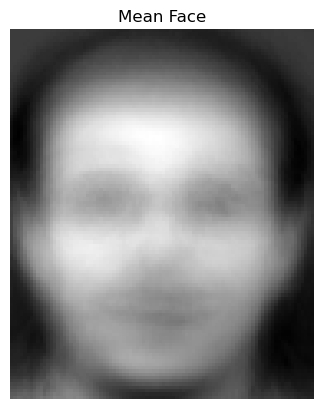

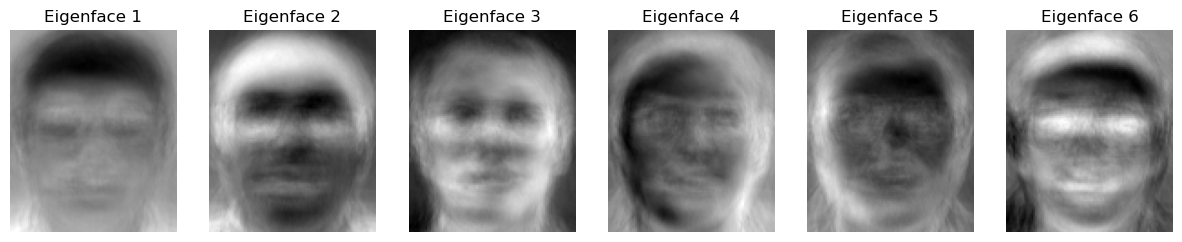

In [30]:
import matplotlib.pyplot as plt

# Reshape and display the mean face
mean_face_img = mean_face.reshape(112, 92)
plt.imshow(mean_face_img, cmap='gray')
plt.title("Mean Face")
plt.axis('off')
plt.show()

# Visualize the first few Eigenfaces
num_eigenfaces_to_show = 6
fig, axes = plt.subplots(1, num_eigenfaces_to_show, figsize=(15, 5))
for i in range(num_eigenfaces_to_show):
    eigenface = np.real(eigenvectors[:, i]).reshape(112, 92)
    axes[i].imshow(eigenface, cmap='gray')
    axes[i].set_title(f"Eigenface {i+1}")
    axes[i].axis('off')
plt.show()

In [31]:
# Select the top 'k' Eigenfaces
k = 50 # You can experiment with different values
eigenfaces = eigenvectors[:, :k]

# Project the training and test images into the new space
X_train_pca = np.dot(X_train_centered, eigenfaces)
# Center the test data using the mean of the training data
X_test_centered = X_test - mean_face
X_test_pca = np.dot(X_test_centered, eigenfaces)

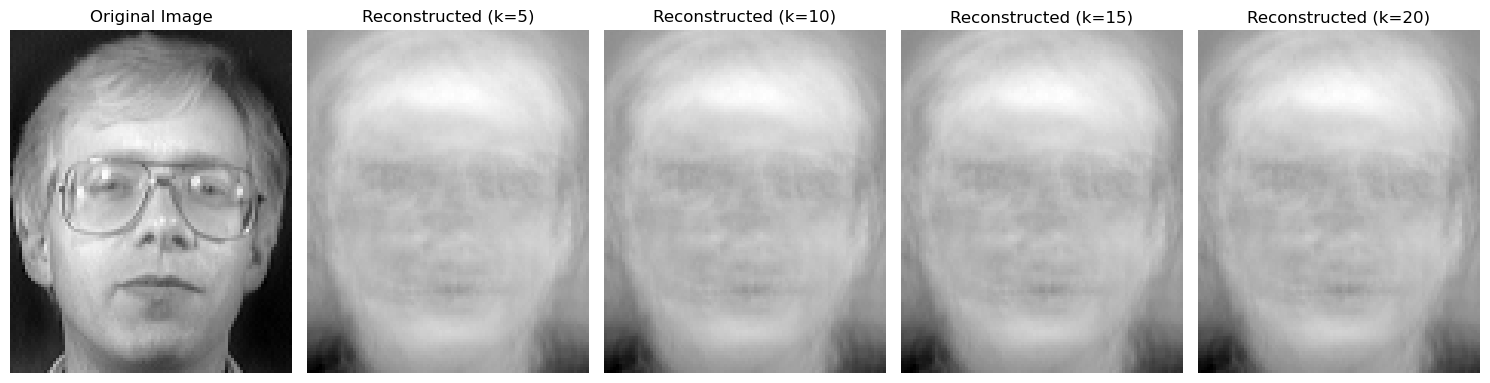

In [50]:
# Assuming X_test, mean_face, and eigenvectors are already computed
# from your previous code blocks.
k_values=[5,10,15,20]
# Call the function to display the image reconstruction plots
compare_reconstruction(X_test, mean_face, eigenvectors, k_values)

In [32]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Create and train the Nearest Neighbor classifier
knn_classifier = KNeighborsClassifier(n_neighbors=1)
knn_classifier.fit(X_train_pca, y_train)

# Predict on the test data
y_pred = knn_classifier.predict(X_test_pca)

# Evaluate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with k={k} principal components: {accuracy*100:.2f}%")

Accuracy with k=50 principal components: 95.00%


Accuracy with k=1: 11.25%
Accuracy with k=2: 43.75%
Accuracy with k=3: 71.25%
Accuracy with k=4: 83.75%
Accuracy with k=5: 90.00%
Accuracy with k=6: 92.50%
Accuracy with k=7: 92.50%
Accuracy with k=8: 92.50%
Accuracy with k=9: 93.75%
Accuracy with k=10: 92.50%
Accuracy with k=11: 93.75%
Accuracy with k=12: 93.75%
Accuracy with k=13: 93.75%
Accuracy with k=14: 93.75%
Accuracy with k=15: 93.75%
Accuracy with k=16: 93.75%
Accuracy with k=17: 93.75%
Accuracy with k=18: 93.75%
Accuracy with k=19: 93.75%
Accuracy with k=20: 93.75%
Accuracy with k=21: 93.75%
Accuracy with k=22: 93.75%
Accuracy with k=23: 95.00%
Accuracy with k=24: 95.00%
Accuracy with k=25: 95.00%
Accuracy with k=26: 95.00%
Accuracy with k=27: 95.00%
Accuracy with k=28: 95.00%
Accuracy with k=29: 95.00%
Accuracy with k=30: 95.00%


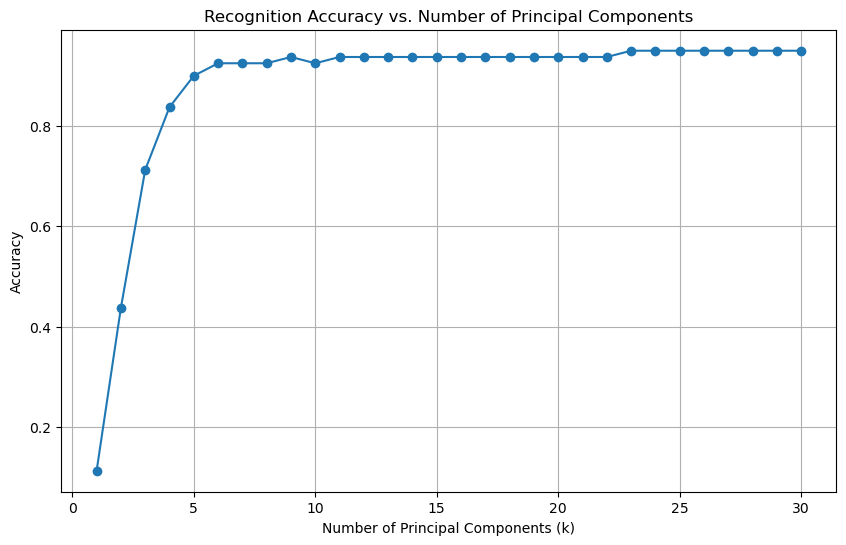

In [37]:
accuracy_scores = []
# Define k_values to match the loop range
k_values = range(1, 31) 

# IMPORTANT: Center the test data using the mean of the TRAINING data
X_test_centered = X_test - mean_face

for k in k_values:
    # Select the top 'k' Eigenfaces
    eigenfaces_k = eigenvectors[:, :k]

    # Project the training and test images into the new space
    X_train_centered = X_train - mean_face
    X_train_pca_k = np.dot(X_train_centered, eigenfaces_k)
    X_test_pca_k = np.dot(X_test_centered, eigenfaces_k)

    # Create and train the Nearest Neighbor classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=1)
    knn_classifier.fit(X_train_pca_k, y_train)

    # Predict on the test data and evaluate accuracy
    y_pred_k = knn_classifier.predict(X_test_pca_k)
    accuracy_k = accuracy_score(y_test, y_pred_k)
    accuracy_scores.append(accuracy_k)
    print(f"Accuracy with k={k}: {accuracy_k * 100:.2f}%")

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores, marker='o')
plt.title("Recognition Accuracy vs. Number of Principal Components")
plt.xlabel("Number of Principal Components (k)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()